# Code to analyse difference sensation levels at 65 dB with signal at best ear side

22 July 2023 Guido Cattani

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [3]:
from scipy.stats import shapiro as shapiro
from scipy.stats import ttest_rel as ttest_rel
from scipy.stats import wilcoxon as wilcoxon

In [4]:
# read difference sensation levels BC - AC simulated with a 65 dB ISDS input signal at Best ear side (90 degree angle)
def read_diff_sl():
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Calculated_data/Diff_SL_65dB_S_bestearside.csv'
    p_in = Path(f_in)   
    df = pd.read_csv(p_in)
    df.set_index('Study_ID', inplace=True)
    return df

In [5]:
# read BC sensation levels simulated with a 65 dB ISDS input signal at Best ear side
def read_bc_sl():
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Calculated_data/BC_SL_65dB_270deg.csv'
    p_in = Path(f_in)   
    df = pd.read_csv(p_in)
    df.set_index('Study_ID', inplace=True)
    return df

In [6]:
# read AC sensation levels simulated with a 65 dB ISDS input signal at Best ear side
def read_ac_sl():
    f_in = '/media/guido/LACIE/Cingle_Guido/Master/Implant/Calculated_data/AC_SL_65dB_90deg.csv'
    p_in = Path(f_in)   
    df = pd.read_csv(p_in)
    df.set_index('Study_ID', inplace=True)
    return df

In [7]:
def list_freq():
    data = read_diff_sl()
    clmns = data.columns
    l = list()
    for clm in clmns:
        l.append(clm)
    return l

In [8]:
def new_freq():
    l = list_freq()
    l2 = list()
    for s in l:
        s = s.rstrip('_Hz')
        s = s.lstrip('f_')
        f = int(s)
        l2.append(f)
    return l2

In [9]:
def dict_freq():
    l = list_freq()
    l2 = new_freq()
    d = dict()
    for i in range(len(l)):
        d.update({l[i] : l2[i]})
    return d

In [10]:
def show_data():    
    # adjust column names, change format columns labels 'f_Hz' to f
    data = read_diff_sl()
    d = dict_freq()
    data = data.rename(columns=d)
    return data

In [11]:
def cal_quantile(df):
    quantiles = [0.10, 0.50, 0.90]
    q = (df.quantile(q=quantiles)).round(1)
    q = q.reset_index()
    diq = {0:'Diff. SL P10', 1:'Diff. SL P50', 2:'Diff. SL P90'} 
    q = q.rename(index=diq)
    q.drop('index', axis=1, inplace=True)
    return q

In [12]:
def descriptive_stat(df):
    # calculate quantiles
    quantiles = df.quantile([0.1, 0.5, 0.9]).round(1)
    quantiles.index = ['P10', 'P50', 'P90']
 
    # calculate mean and standard deviation
    mean_values = (pd.DataFrame({'Mean': df.mean().round(1)})).T
    std_values = (pd.DataFrame({'St. dev.': df.std().round(1)})).T

    # perform Shapiro test 
    sht = shapiro_test_norm(df)

    # combine results into a single DataFrame
    res = pd.concat([quantiles, mean_values, std_values, sht])
 
    return res

In [13]:
def shapiro_test_norm(df):
    ''' Perform the Shapiro-Wilk test for normality. 
    The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.'''
    
    shapiro_result = df.apply(lambda x: shapiro(x) if len(x) >= 3 else (float('nan'), float('nan')))
    
    shapiro_stats = shapiro_result.apply(lambda x: round(x[0], 3))
    p_values = shapiro_result.apply(lambda x: round(x[1], 3))
    is_normal = p_values >= 0.05
    
    shapiro_test = pd.DataFrame({
        'Shapiro test statistic': shapiro_stats,
        'p-value': p_values,
        'normally distributed': is_normal
    }).transpose()
    
    return shapiro_test

In [14]:
def t_test_rel(df1, df2):
    ''' Calculate the t-test on TWO RELATED samples of scores, a and b. 
    This is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.'''

    ttest_result = df1.apply(lambda x: ttest_rel(x, df2[x.name]) if len(x) >= 3 else (float('nan'), float('nan')))

    ttest_stats = ttest_result.apply(lambda x: round(x[0], 3))
    p_values = ttest_result.apply(lambda x: round(x[1], 3))

    ttest = pd.DataFrame({
        'ttest statistic': ttest_stats,
        'p-value ttest': p_values,
    }).transpose()
    
    d = dict_freq()
    ttest = ttest.rename(columns=d)

    return ttest

In [15]:
def wilcoxon_signed_rank(df):
    ''' Compare output of BAHA5P at 65 dB, first fit versus maximal stable
    The Wilcoxon signed-rank test tests the null hypothesis that 
    two related paired samples come from the same distribution. 
    In particular, it tests whether the distribution of the differences x - y is symmetric 
    about zero. It is a non-parametric version of the paired T-test.'''
    
    wilcoxon_result = df.apply(lambda x: wilcoxon(x) if len(x) >= 3 else (float('nan'), float('nan')))
    
    wilcoxon_stats = wilcoxon_result.apply(lambda x: round(x[0], 3))
    p_values = wilcoxon_result.apply(lambda x: round(x[1], 3))
    
    wilcoxon_test = pd.DataFrame({
        'wilcoxon test statistic': wilcoxon_stats,
        'p-value wilcoxon': p_values,
    }).transpose()
    
    return wilcoxon_test

In [16]:
def normal_couple(df1, df2):
    # normality of 2 df
    normality1 = shapiro_test_norm(df1).loc['normally distributed']
    normality2 = shapiro_test_norm(df2).loc['normally distributed']
    both_normal = normality1 & normality2
    normality = pd.DataFrame({
        'BC SL is normal distributed': normality1,
        'AC SL is normal distributed': normality2,
        'BC SL & AC SL are normal distributed': both_normal
    }).transpose()
    d = dict_freq()
    normality = normality.rename(columns=d)
    normality = normality.astype(bool)
    return normality

In [17]:
def comparison():
    bc_sl = read_bc_sl()
    ac_sl = read_ac_sl()
    diff = show_data()
    
    normal2check = normal_couple(bc_sl, ac_sl)
    
    ttr = t_test_rel(bc_sl, ac_sl)
    ttr = ttr * normal2check.loc['BC SL & AC SL are normal distributed'].replace(False,pd.NA)
    
    wsr = wilcoxon_signed_rank(diff)
    
    des_stat = descriptive_stat(diff)
    
    results = pd.concat([des_stat, normal2check, ttr, wsr])
    
    results.drop(labels = ['BC SL is normal distributed', 'AC SL is normal distributed'], inplace = True)

    return results

In [18]:
data1 = show_data()
data1

,125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000,5000,6300,8000
Study_ID,,,,,,,,,,,,,,,,,,,
34,-44.5,-58.4,-66.7,-67.2,-64.5,-60.9,-49.4,-39.9,-27.8,-12.8,-15.8,-17.4,-14.6,-3.2,5.9,9.7,-16.7,-18.7,-28.5
35,-28.1,-47.4,-60.5,-65.8,-59.4,-50.5,-34.5,-24.0,-14.7,-15.1,-15.1,-15.0,-24.2,-2.0,15.5,15.2,-8.9,-12.0,-27.6
43,-19.6,-37.1,-48.5,-52.3,-48.2,-42.1,-28.3,-22.3,-15.9,-13.5,-19.6,-25.0,-28.4,-18.1,-10.1,-17.8,-22.5,-11.0,-32.3
47,-39.2,-56.7,-68.1,-71.9,-65.5,-57.1,-40.4,-36.8,-29.2,-15.8,-14.5,-11.5,-5.3,-4.6,-0.6,-5.3,-23.1,-22.2,-40.2
50,-40.0,-55.7,-65.5,-67.7,-66.1,-60.0,-48.6,-38.6,-27.6,-20.0,-22.5,-22.9,-17.0,-15.9,-12.7,-13.0,-25.0,-18.3,-34.4
53,-13.9,-31.4,-42.8,-46.6,-46.2,-42.3,-30.5,-20.5,-12.1,-12.5,-12.6,-12.9,-16.2,-18.3,-18.4,-15.9,-34.7,-33.3,-47.6
54,-38.1,-53.8,-63.6,-65.8,-58.8,-47.4,-29.7,-21.0,-15.0,-21.5,-16.5,-11.7,-11.7,-4.4,1.6,0.4,2.5,24.3,22.4
56,-32.0,-47.7,-57.5,-59.7,-57.7,-52.6,-39.3,-23.0,-13.1,-24.7,-18.7,-12.1,-6.4,2.4,10.2,7.0,14.7,37.3,22.7
59,-46.7,-64.2,-75.6,-79.4,-71.7,-58.7,-40.2,-34.0,-26.9,-22.3,-20.3,-17.6,-15.5,-14.5,-10.3,-9.7,-28.1,-29.7,-51.7


In [19]:
# perform calculation of quantiles 10, 50, 90

quantiles = [0.10, 0.50, 0.90]
q = cal_quantile(data1)

In [20]:
comp = comparison()
comp

/home/guido/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000,5000,6300,8000
P10,-44.9,-60.7,-73.2,-75.7,-71.8,-61.5,-48.7,-38.7,-29.1,-28.6,-25.2,-25.2,-22.5,-17.7,-16.3,-15.9,-32.2,-30.0,-45.4
P50,-39.1,-54.5,-65.2,-67.2,-64.1,-55.2,-39.8,-30.6,-21.1,-19.6,-18.8,-16.2,-14.4,-7.1,-3.3,-7.5,-22.8,-20.0,-34.5
P90,-27.2,-44.5,-54.4,-56.3,-53.2,-46.9,-30.4,-22.2,-14.5,-12.7,-14.3,-11.2,-4.8,1.9,10.6,7.4,-6.1,3.8,2.2
Mean,-36.1,-52.7,-63.3,-66.3,-62.6,-54.5,-39.5,-30.5,-22.1,-20.3,-19.4,-17.0,-12.9,-8.0,-2.7,-4.8,-20.2,-15.9,-29.4
St. dev.,8.7,8.3,8.2,8.5,7.7,7.2,7.3,6.9,6.8,7.3,5.7,6.8,7.9,7.1,10.1,10.1,12.4,18.0,20.6
Shapiro test statistic,0.912,0.926,0.944,0.956,0.965,0.963,0.969,0.917,0.942,0.954,0.905,0.894,0.978,0.955,0.967,0.916,0.87,0.757,0.734
p-value,0.07,0.131,0.287,0.47,0.653,0.608,0.729,0.088,0.259,0.43,0.052,0.032,0.913,0.457,0.682,0.083,0.012,0.0,0.0
normally distributed,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,False,False,False
BC SL & AC SL are normal distributed,False,False,False,False,False,True,False,True,True,False,True,False,True,False,False,False,False,False,False
ttest statistic,<NA>,<NA>,<NA>,<NA>,<NA>,-34.029,<NA>,-19.894,-14.536,<NA>,-15.27,<NA>,-7.315,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [21]:
# name file for stat results
f_ar = "diff_SL_Sbest.csv"

In [22]:
# save stat to file
d_ar = "/media/guido/LACIE/Cingle_Guido/Master/Implant/Analysis_Results/"
p_ar = Path(d_ar + f_ar)
comp.to_csv(p_ar)

In [23]:
# convert Pandas object in numpy array
lf = new_freq()
frqc = np. array(lf , dtype=int)
p10 = q.iloc[0].T.to_numpy()
median = q.iloc[1].T.to_numpy()
p90 = q.iloc[2].T.to_numpy()
bh5 = data1.T.to_numpy()
len(bh5)

19

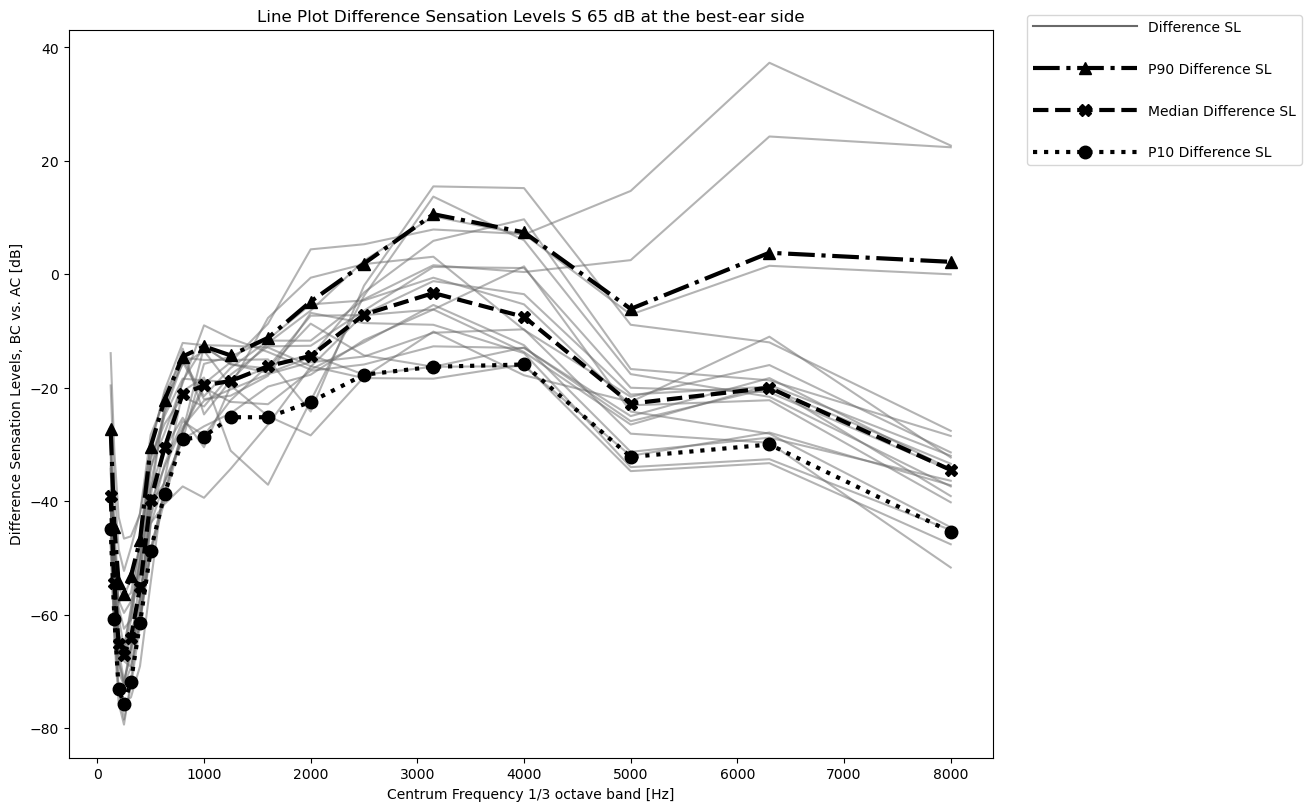

In [24]:
# make a figure to plot difference sensation level (BC - AC)

plt.rcParams['axes.facecolor'] = 'white'

fig, (ax) = plt.subplots(1, constrained_layout=True)

hh = 8
ww = hh * 1.6180339887
ww = round (ww, 0)

fig.set_figheight(hh)
fig.set_figwidth(ww)
# make the line plot

ax.set(xlabel='Centrum Frequency 1/3 octave band [Hz]', ylabel='Difference Sensation Levels, BC vs. AC [dB]',
       title='Line Plot Difference Sensation Levels S 65 dB at the best-ear side')

# plot lines based on numpy arrays
ax.plot(frqc, bh5, color="dimgrey", alpha=0.5, label='Difference SL')
ax.plot(frqc, median, color='black', marker='X', linestyle='dashed', linewidth=3, markersize=9)
ax.plot(frqc, p10, color='black', marker='o', linestyle='dotted', linewidth=3, markersize=9)
ax.plot(frqc, p90, color='black', marker='^', linestyle='dashdot', linewidth=3, markersize=9)


# make a legend
leg_line = mlines.Line2D([], [], color="dimgrey", label='Difference SL')

leg_p90 = mlines.Line2D([], [], color='black', marker='^', linestyle='dashdot', 
                            linewidth=3, markersize=9, label='P90 Difference SL')
leg_med = mlines.Line2D([], [], color='black', marker='X', linestyle='dashed', 
                            linewidth=3, markersize=9, label='Median Difference SL')
leg_p10 = mlines.Line2D([], [], color='black', marker='o', linestyle='dotted', 
                            linewidth=3, markersize=9, label='P10 Difference SL')
     

leg = plt.legend(handles=[leg_line, leg_p90, leg_med, leg_p10], 
                 bbox_to_anchor=(1.03, 1.03), loc='upper left', labelspacing=2., handlelength=7.5)

# save the figure
plt.savefig('/media/guido/LACIE/Cingle_Guido/Master/Implant/Analysis_Graphs/Diff_SL_Sbest.tiff', 
            transparent=False, dpi=500, bbox_inches="tight")

plt.show() # show the figure